In [2]:
import seaborn as sns
import pandas as pd
import csv
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random as rd
from past.utils import old_div
import os
import warnings
warnings.filterwarnings("ignore")

In [27]:
data_file = 'Data/CNM_004.csv'
#data_file = 'Data/CNM_Anaesth.csv'
#data_file = 'Data/CNM_M2_W1_D1.csv'
#data_file = 'CNM_Anaesth.csv'

#data_file = 'Data/M1_W2_D1_CNMFe_001.csv'

compute_z_score = False
draw_z_score = False
zoom = False
zoom_begin_t = 0
zoom_end_t = 300
draw_tsv_files = True
draw_events = False
#events_file = 'Data/CNM_Events_Anaesth.csv'
#events_file = 'CNM_Events_Anaesth.csv'

In [28]:
#read-in signal values
df = pd.read_csv(data_file)

if_undecided = False # Set to False to only use accepted cols, True to include undecided as well
cols = df.loc[0].isin([" accepted"," undecided"]) if if_undecided else df.loc[0].eq(" accepted") 
cols = cols.index[cols]
cols = list(cols)
cols_ori = cols

df_data = df[[" ",*cols]].drop([0])
df_data = df_data.astype(np.double)

df_data['next_row_value'] = df_data[' '].shift(-1)
idx = df_data.loc[df_data['next_row_value'] > df_data[' '] + 2].index

segments = [0]

for i,el in enumerate(idx):
    diff_normal = df_data.loc[el][" "] - df_data.loc[el-1][" "]
    diff_missing = df_data.loc[el+1][" "] - df_data.loc[el][" "]
    segments.append(df_data.loc[el][" "])
    df_data.loc[el+1:,' '] -= diff_missing - diff_normal
df_data = df_data.dropna()

# df_data.describe()

trace_std = {}
if compute_z_score:
    for i in range(len(cols)):
        mean = df_data[cols[i]].mean()
        std = df_data[cols[i]].std()
        df_data[cols[i]] = (df_data[cols[i]] - mean) / std
        trace_std[cols[i]] = std
 


In [29]:
if draw_events:
    ev = pd.read_csv(events_file)
    cells = list(set(ev.xs(ev.columns[1],1)))
    cells.sort()
    events = {c : ev.loc[ev[ev.columns[1]].isin([c])].iloc[:,0].tolist() for c in cells}

In [30]:
### Setup a map between TSV classes and colors

data_x_palette = {
    1: '#470fba', # purple
    2: '#525050', # grey
    3: '#84bf36', # lime green
    4: '#a584d6',#' baby blue
    5: '#f0548d', # greyish red
    6: '#f58231', # greyish blue
    7: '#f5ad42', # Orange
}

data_x_palette = {
    1: '#858481', # dark grey -- cup up
    2: '#cccac6', # light grey --- cup down
    3: '#6e05ab', # purple -- CS+ 
    4: '#2462bf',# light blue -- CS- 
    5: '#bf2474', # dark red -- approach
    6: '#f2c2bd', # light pink -- avoidance
    7: '#f5ad42', # Orange
}

def generate_squares(df_sq_in,segment):
    data_x_locations = []
    data_x_colors = []
    for col in df_sq_in.columns[1:]:
        segmentt = False
        data = []
        for i,val in enumerate(df_sq_in[col]):
            if(val == 1 and not segmentt):
                data.append(df_sq_in.iloc[i]['time'])
                segmentt = True
            elif(val == 0 and segmentt):
                data.append(df_sq_in.iloc[i-1]['time'] - data[0])
                data_x_locations.append(data)
                data_x_colors.append(int(col))
                data = []
                segmentt = False

    for el in data_x_locations:
        el[0] += segments[segment]
        
    return data_x_locations, data_x_colors
    


In [31]:
selected_class = [1,2,3,4,5,6]
def get_rectangle(x,y,w,h,c,j):
    alpha = 0.6 if j in selected_class else 0
    return mpatches.Rectangle((x,y),w,h, 
                        fill = True,
                        #alpha=0.6,
                        alpha=alpha,
                        linewidth=0,
                        color = c)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


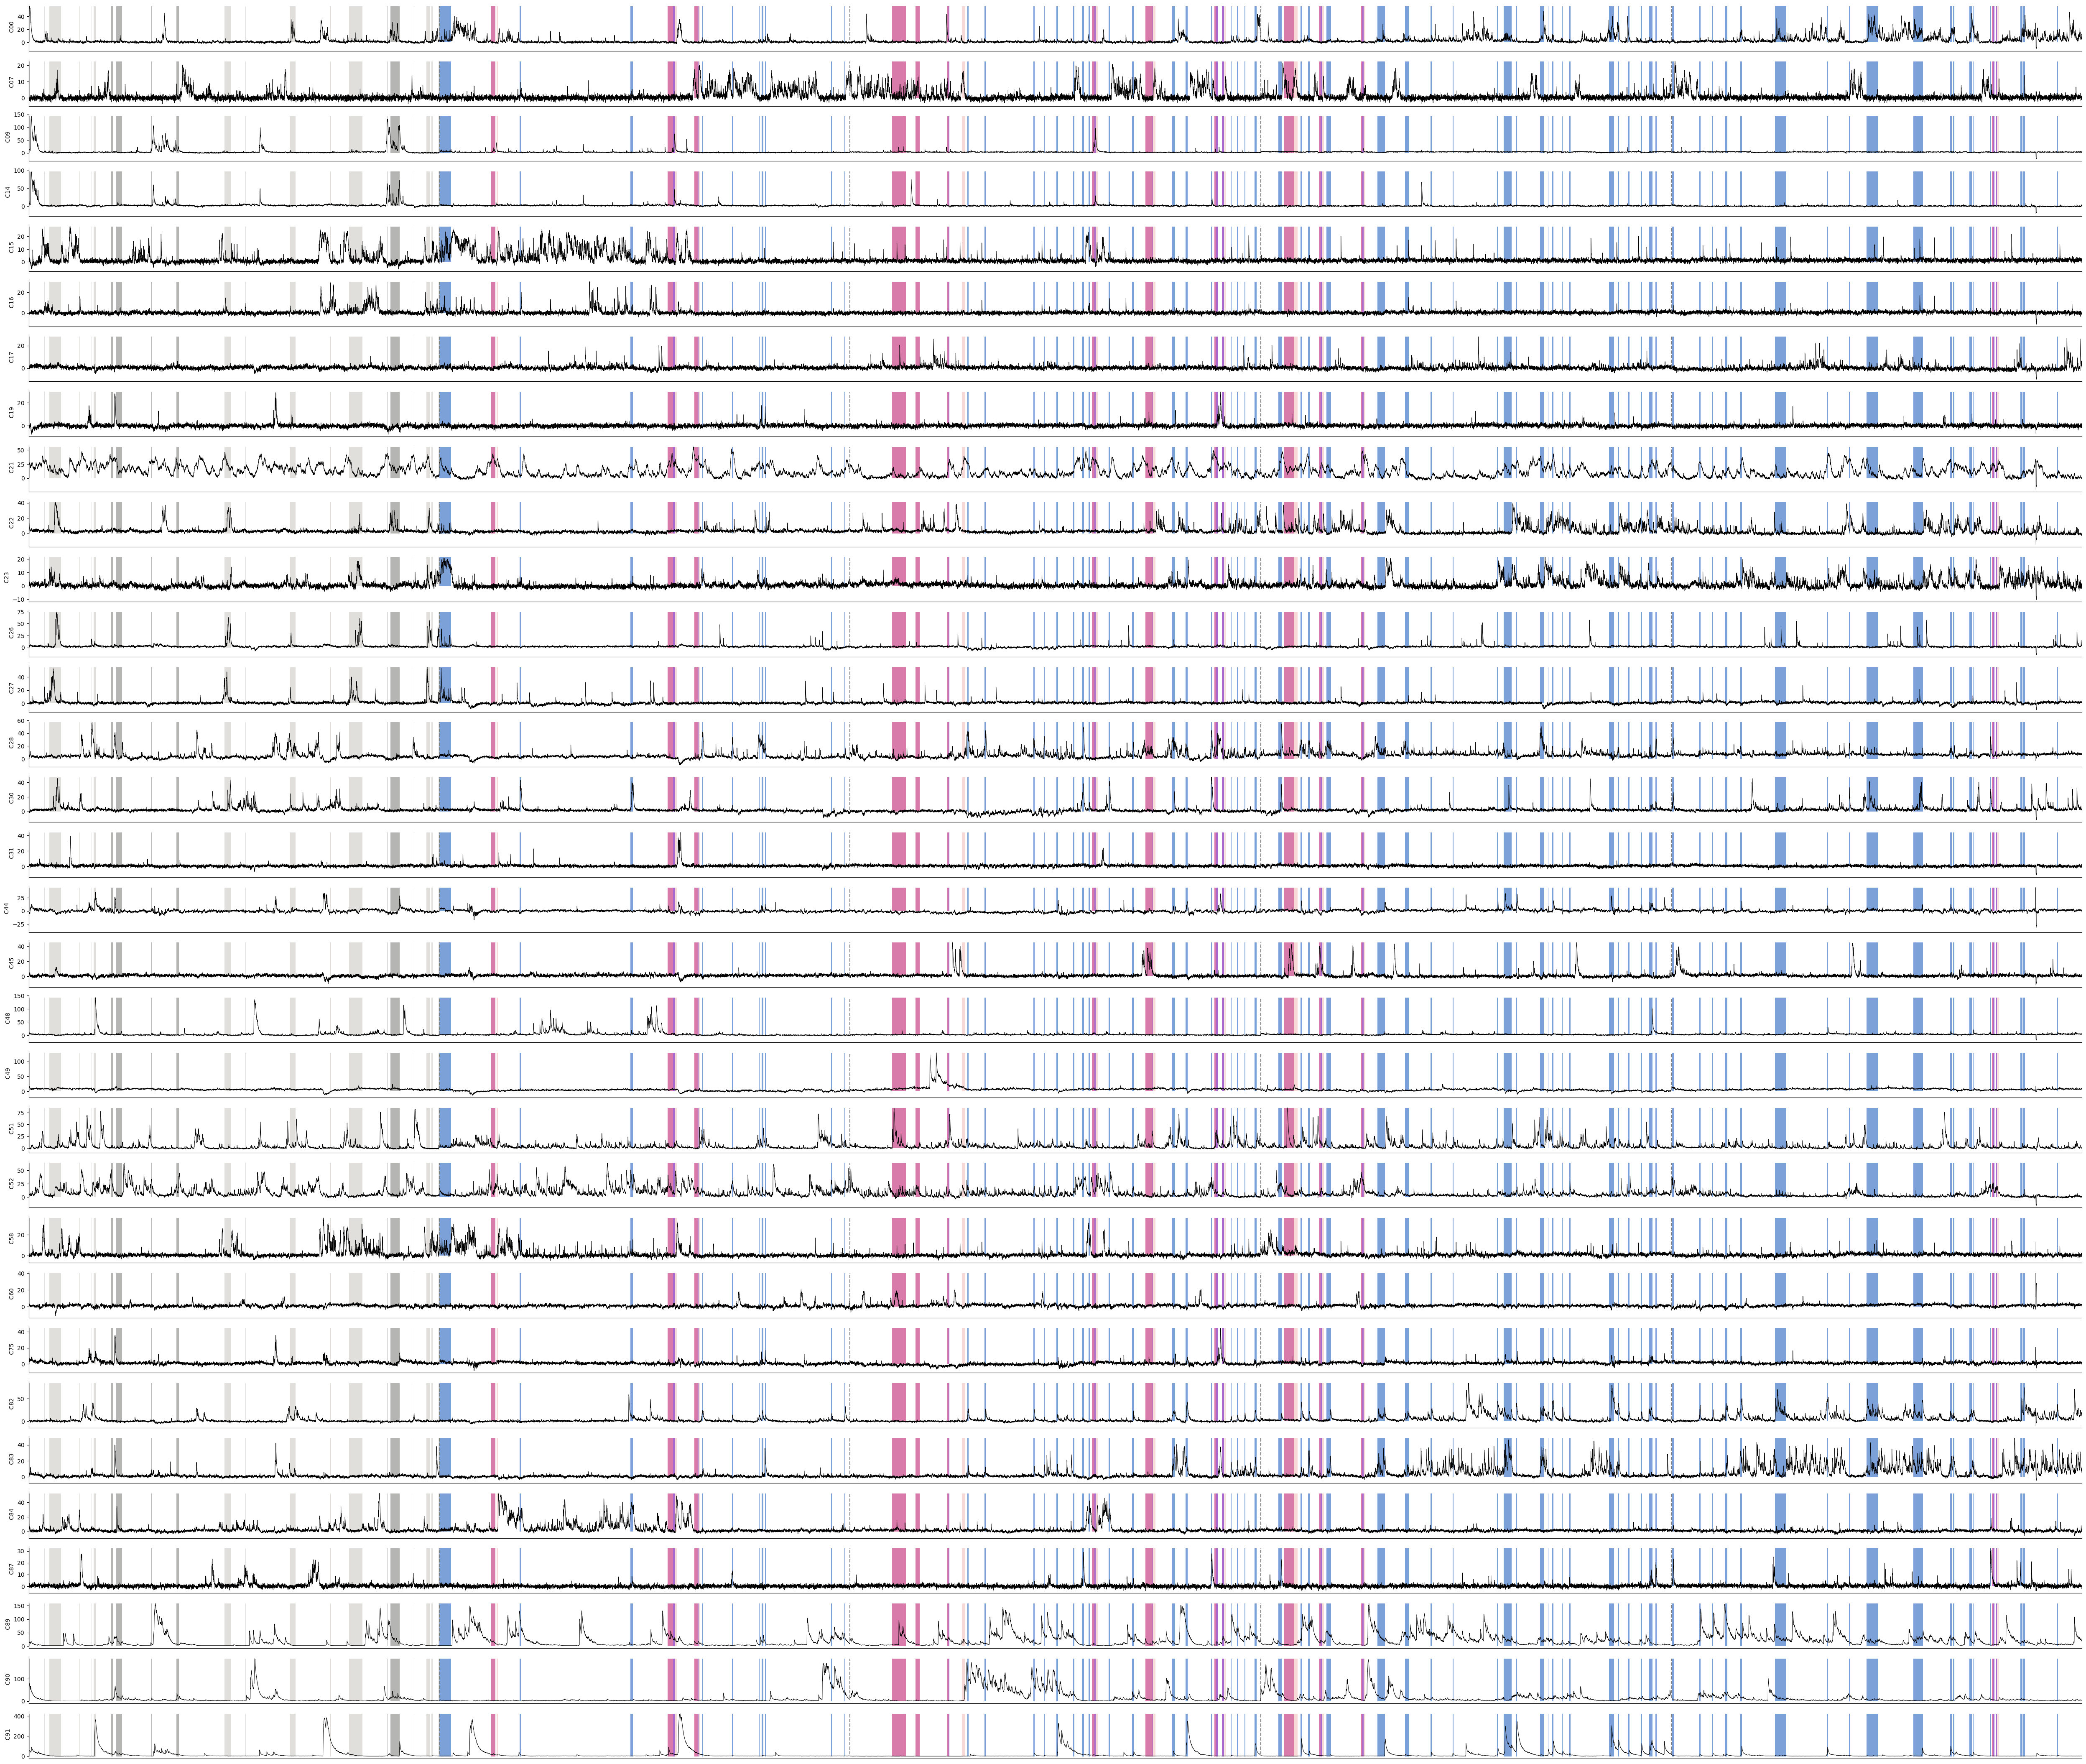

In [33]:
palette = sns.color_palette('viridis',as_cmap=True).colors
# cols = cols_ori[:2] # uncomment this line for full output.
step = int(len(palette)/len(cols))

# UNCOMMENT THIS LINE TO MAKE ALL TRACES BLACK
# palette = ['#000' for i in range(len(palette))]
fig, ax = plt.subplots(len(cols), 1)
fig = plt.gcf()
fig.set_size_inches([50,len(cols)*1.322])

color_indices = [i*step for i in range(len(cols))]
rd.seed(18)
rd.shuffle(color_indices)
#Shuffle colors
# color_indices = [0, 100, 25, 200, 50, 175, 75, 125, 150, 225]

if draw_tsv_files:
    # read in files with data <-> class to generate colored blocks for each class
    tsvfiles = [f for f in os.listdir('Data') if os.path.isfile('Data/' + f) and '.tsv' in f]
    tsvfiles.sort()

xlim_min = df_data.min()[' '] if not zoom else zoom_begin_t
xlim_max = df_data.max()[' '] if not zoom else zoom_end_t
   
    
for i in range(len(cols)):
    
    max_val = df_data[cols[i]].max()
    min_val = df_data[cols[i]].mean()
    
    if draw_tsv_files:
        for ind,tsv in enumerate(tsvfiles):
            df_sq = pd.read_csv('Data/' + tsv, sep='\t')
            df_sq = df_sq[101:]
            df_sq = df_sq.astype(np.double)
            df_sq['time']-=5.05

            data_x_locations, data_x_colors = generate_squares(df_sq,ind)
            for j,pair in enumerate(data_x_locations):
                ax[i].add_patch(get_rectangle(pair[0],0,pair[1],max_val,data_x_palette[data_x_colors[j]],data_x_colors[j]))

    #sns.lineplot(data=df_data,x=" ",y=cols[i],ax=ax[i],color='black',lw=0.5)
    sns_ax = sns.lineplot(data=df_data,x=" ",y=cols[i],ax=ax[i],color='black',lw=0.7)
    sns_ax.set(xticklabels=[]) # remove the tick labels
    sns_ax.set(xlabel=None) # remove the axis label
    sns_ax.tick_params(bottom=False) # remove the ticks  
    
    for el in segments:
        ax[i].plot([el,el],[min_val,max_val],linestyle='dashed',color='grey')

    if draw_events and cols[i] in events:
        ev = events[cols[i]]
        ax[i].scatter(ev, [max_val] * len(ev), color='black')

    if compute_z_score and draw_z_score:
        ax[i].plot([xlim_max,xlim_max],[min_val,min_val+2*trace_std[cols[i]]],linestyle='solid',color='green',alpha=0.6,linewidth=10)
        
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].set_xlim([xlim_min,xlim_max])
    
fig.tight_layout()
image_filename = "Figure_AllCells%s%s%s%s" % ("_z" if compute_z_score else "", "_tsv" if draw_tsv_files else "", "_events" if draw_events else "", "_zoom_%.0f_%.0f" % (zoom_begin_t, zoom_end_t) if zoom else "")
fig.savefig(image_filename + ".jpg", dpi=600)
fig.savefig(image_filename + ".eps", format='eps', dpi=600)



0.0002626924460428226
